In [3]:
import polars as pl
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
import json
from urllib.request import urlopen

CSV_PATH = Path("players-csv/2022-09-26_players.csv")

df = pl.read_csv(str(CSV_PATH))
df.head()


match_id,# season,period,game-ver,lobby,mode,stage,time,win,knockout,rank,power,alpha-inked,alpha-ink-percent,alpha-count,alpha-color,alpha-theme,bravo-inked,bravo-ink-percent,bravo-count,bravo-color,bravo-theme,medal1-grade,medal1-name,medal2-grade,medal2-name,medal3-grade,medal3-name,event,weapon,kill-assist,kill,assist,death,special,inked,abilities,player,team,player_no
i64,str,str,str,str,str,str,i64,str,bool,str,str,i64,f64,i64,str,str,i64,f64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64
0,"""Drizzle Season 2022""","""2022-09-26T00:00:00+00:00""","""1.1.1""","""bankara_open""","""yagura""","""chozame""",204,"""alpha""",true,null,null,null,null,100,null,null,null,null,0,null,null,"""gold""","""#1 Overall Splatter""","""gold""","""#1 Enemy Splatter""","""gold""","""Record-Score Setter""",null,"""sshooter""",17,13,4,4,5,866,null,"""A1""","""alpha""",1
0,"""Drizzle Season 2022""","""2022-09-26T00:00:00+00:00""","""1.1.1""","""bankara_open""","""yagura""","""chozame""",204,"""alpha""",true,null,null,null,null,100,null,null,null,null,0,null,null,null,null,null,null,null,null,null,"""campingshelter""",8,3,5,5,3,393,null,"""A2""","""alpha""",2
0,"""Drizzle Season 2022""","""2022-09-26T00:00:00+00:00""","""1.1.1""","""bankara_open""","""yagura""","""chozame""",204,"""alpha""",true,null,null,null,null,100,null,null,null,null,0,null,null,null,null,null,null,null,null,null,"""variableroller""",3,2,1,4,6,1006,null,"""A3""","""alpha""",3
0,"""Drizzle Season 2022""","""2022-09-26T00:00:00+00:00""","""1.1.1""","""bankara_open""","""yagura""","""chozame""",204,"""alpha""",true,null,null,null,null,100,null,null,null,null,0,null,null,null,null,null,null,null,null,null,"""52gal""",12,12,0,3,3,740,null,"""A4""","""alpha""",4
0,"""Drizzle Season 2022""","""2022-09-26T00:00:00+00:00""","""1.1.1""","""bankara_open""","""yagura""","""chozame""",204,"""alpha""",true,null,null,null,null,100,null,null,null,null,0,null,null,null,null,null,null,null,null,null,"""nautilus47""",7,5,2,9,1,495,null,"""B1""","""bravo""",1


In [ ]:
STAGE_API = "https://stat.ink/api/v3/stage"
WEAPON_API = "https://stat.ink/api/v3/weapon"

def fetch_json(url: str):
    with urlopen(url) as r:
        return json.loads(r.read().decode("utf-8"))

stages = fetch_json(STAGE_API)   # [{key, name:{ja_JP,...}, ...}, ...]
weapons = fetch_json(WEAPON_API) # [{key, name:{ja_JP,...}, ...}, ...]

stage_ja = {s["key"]: s["name"].get("ja_JP", s["key"]) for s in stages}
weapon_ja = {w["key"]: w["name"].get("ja_JP", w["key"]) for w in weapons}

list(stage_ja.items())[:5], list(weapon_ja.items())[:5]


([('yunohana', 'ユノハナ大渓谷'),
  ('gonzui', 'ゴンズイ地区'),
  ('kinmedai', 'キンメダイ美術館'),
  ('mategai', 'マテガイ放水路'),
  ('namero', 'ナメロウ金属')],
 [('52gal', '.52ガロン'),
  ('52gal_deco', '.52ガロンデコ'),
  ('96gal', '.96ガロン'),
  ('96gal_deco', '.96ガロンデコ'),
  ('96gal_sou', '.96ガロン爪')])

/var/folders/0c/mxy1q43d1jxg480rc319w3qr0000gn/T/ipykernel_50472/1431182361.py:30: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("stage").replace(stage_ja, default=pl.col("stage")).alias("stage_ja"),
/var/folders/0c/mxy1q43d1jxg480rc319w3qr0000gn/T/ipykernel_50472/1431182361.py:31: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("weapon").replace(weapon_ja, default=pl.col("weapon")).alias("weapon_ja"),


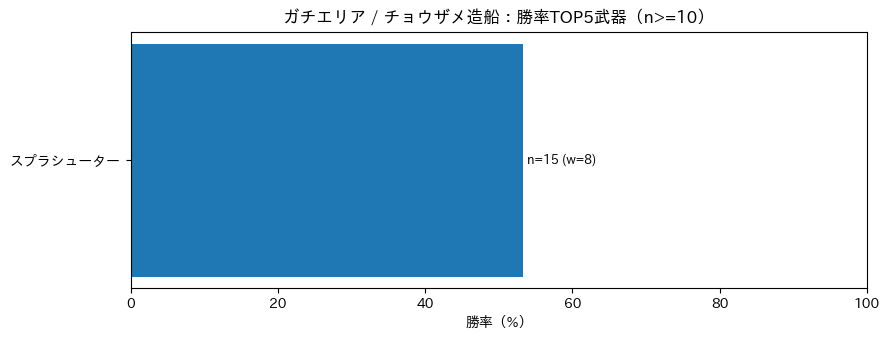

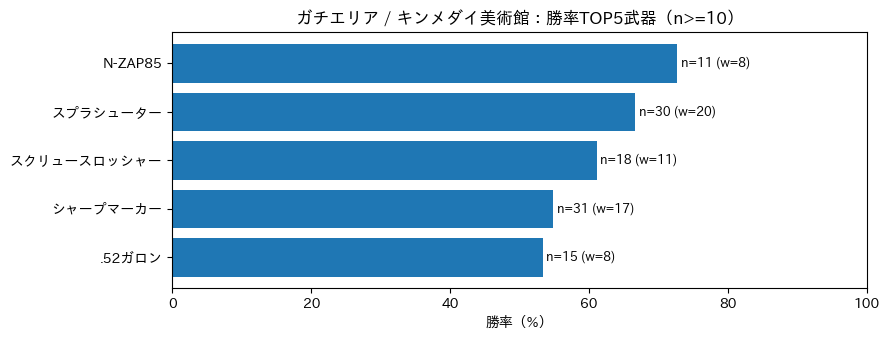

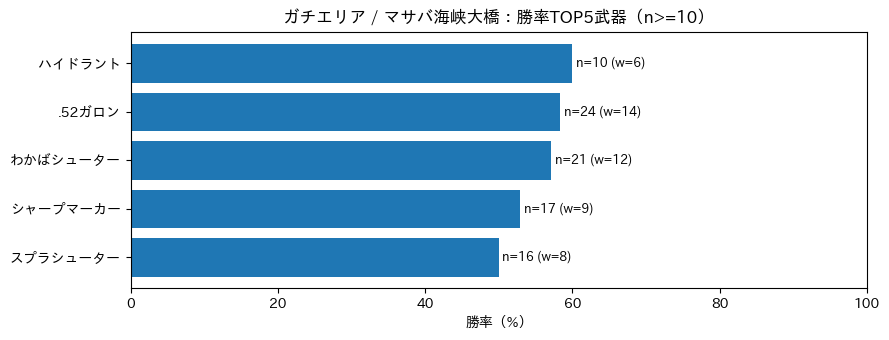

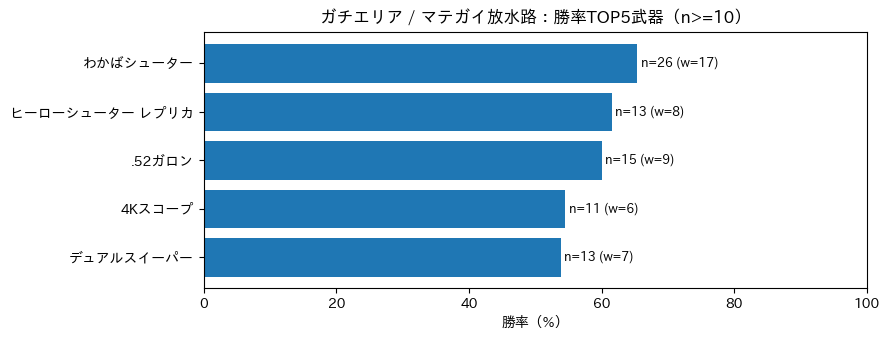

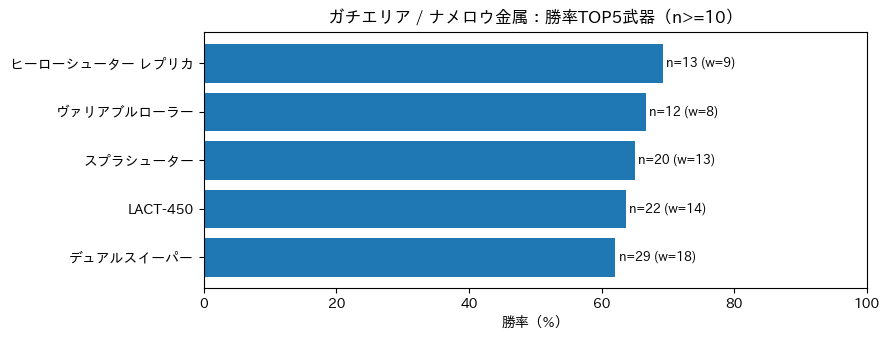

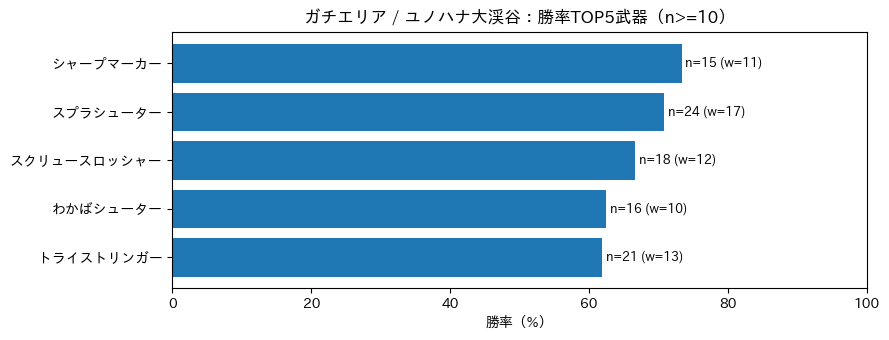

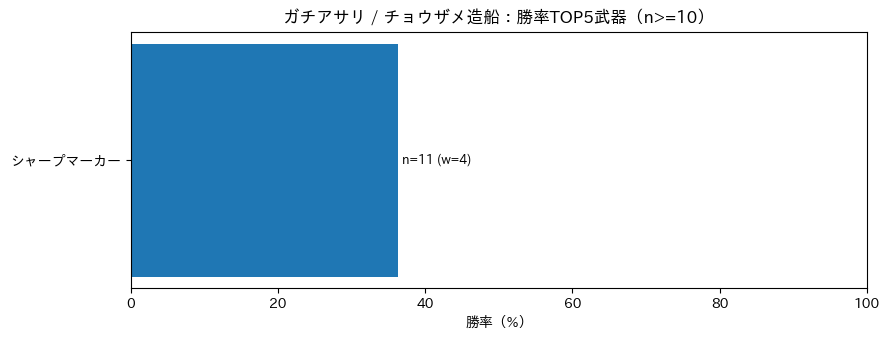

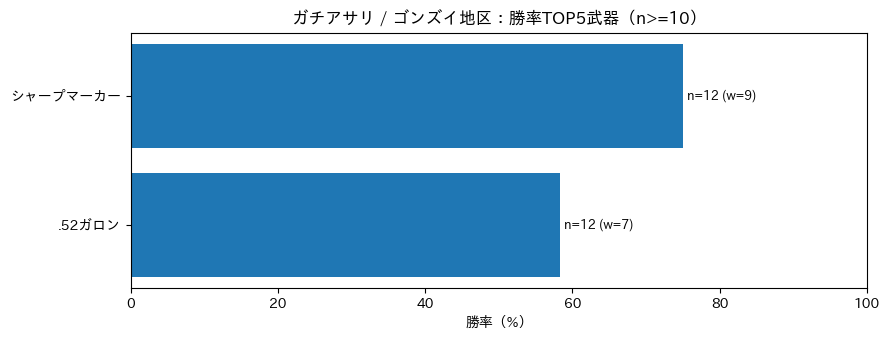

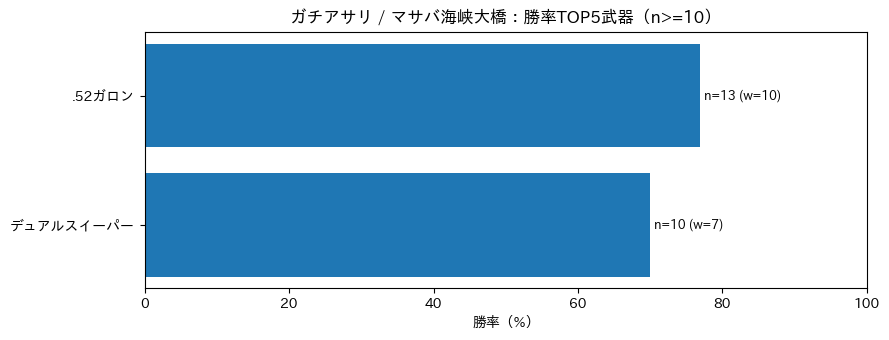

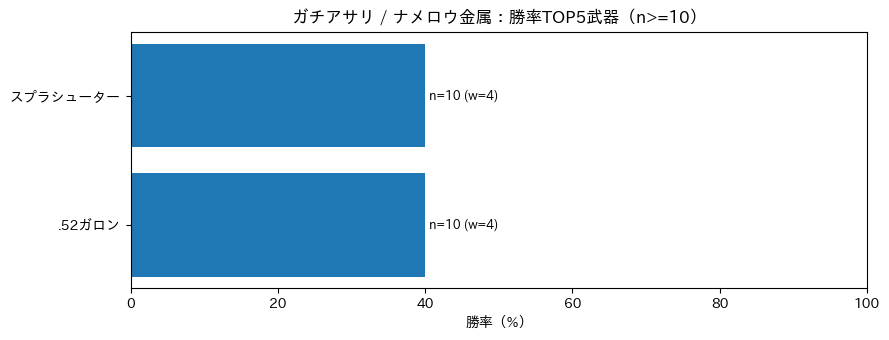

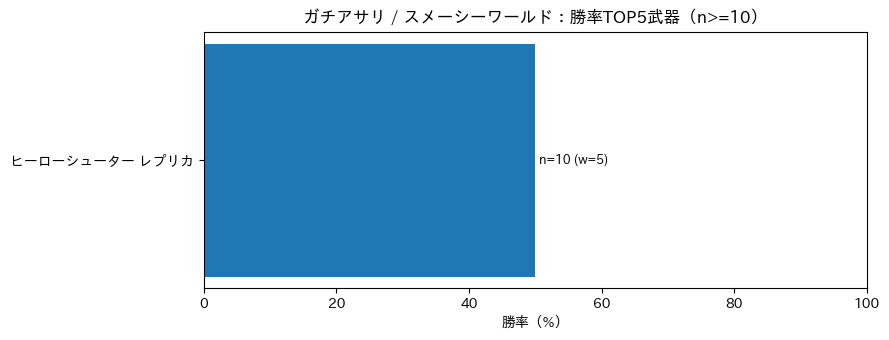

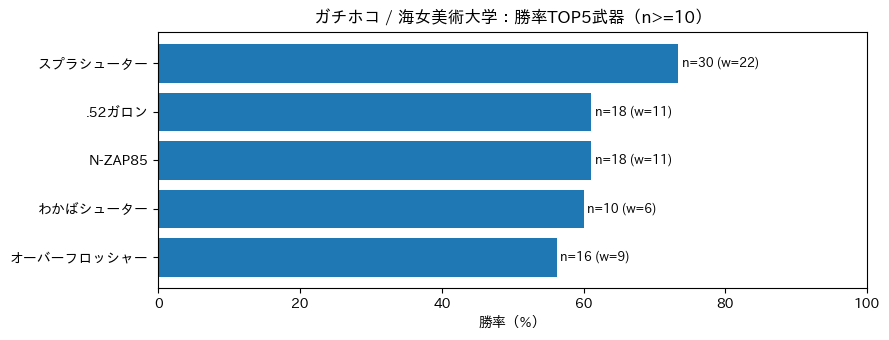

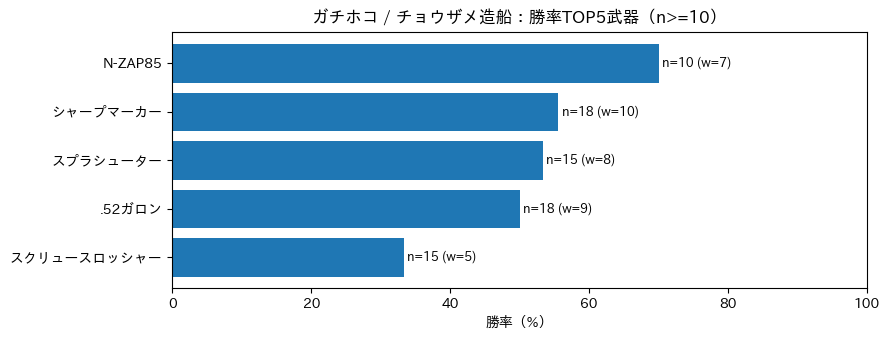

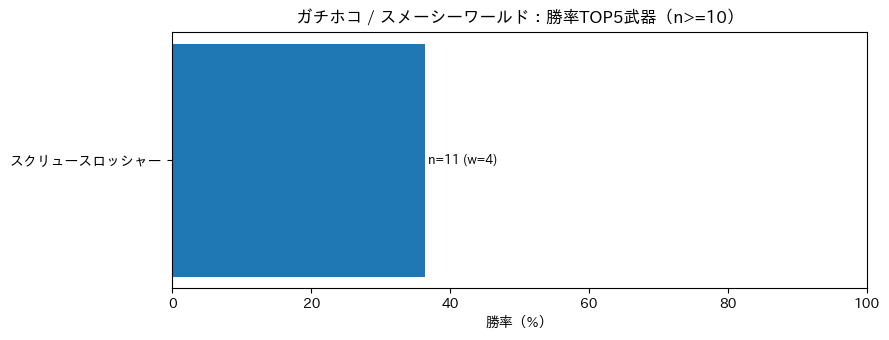

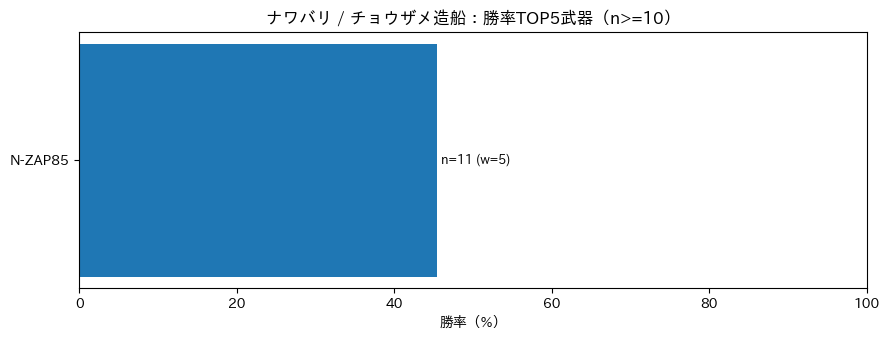

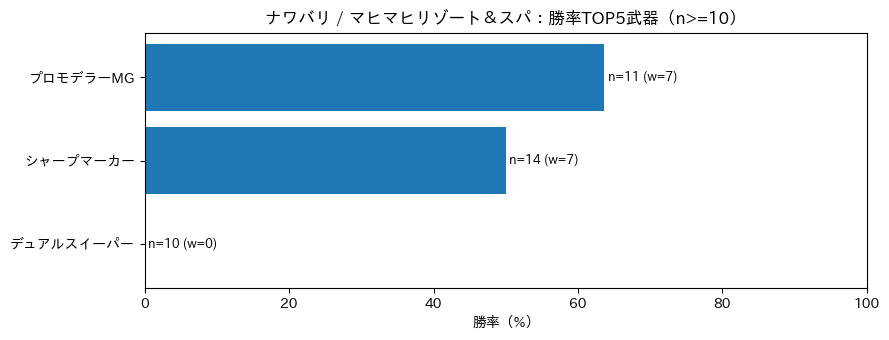

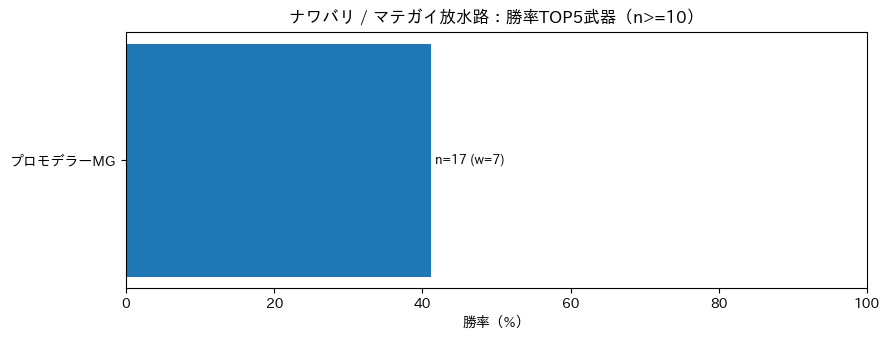

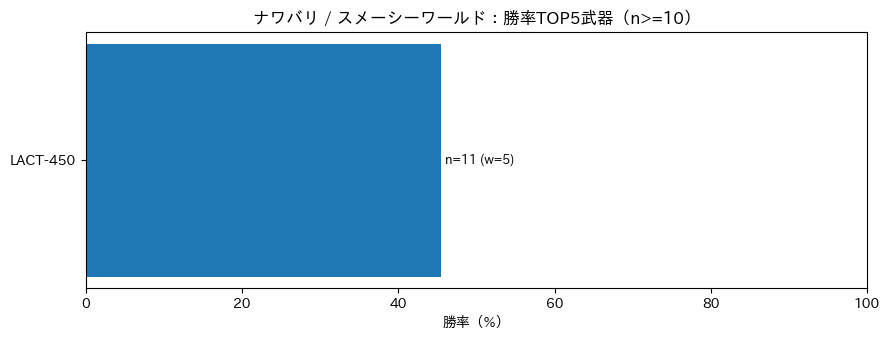

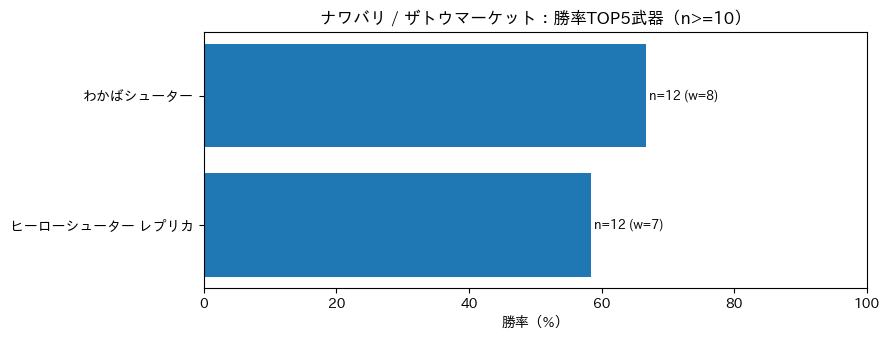

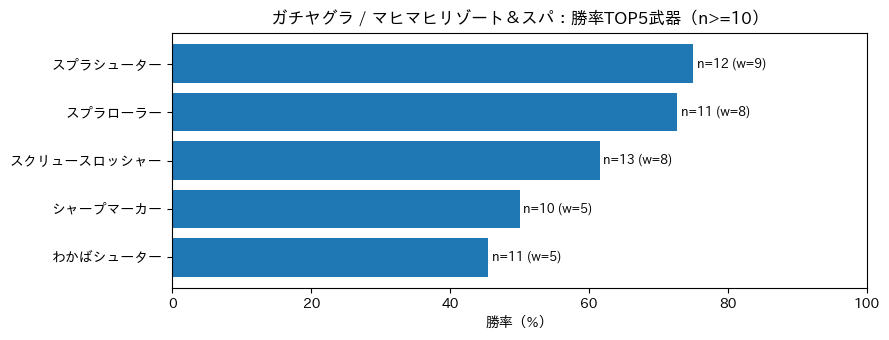

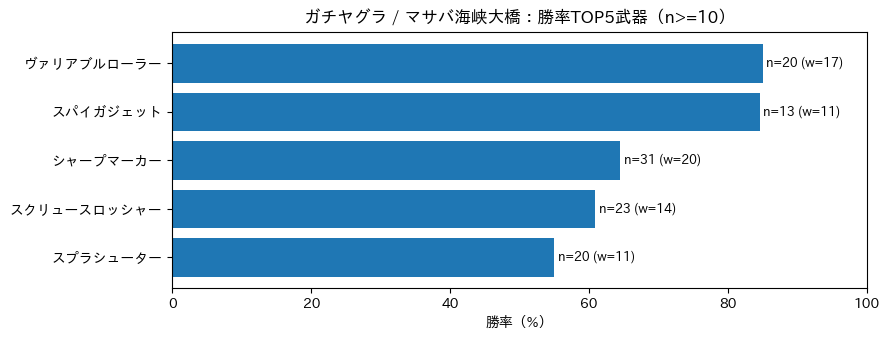

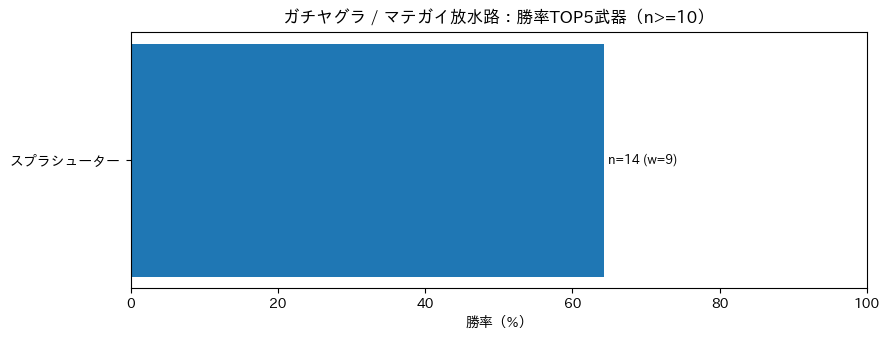

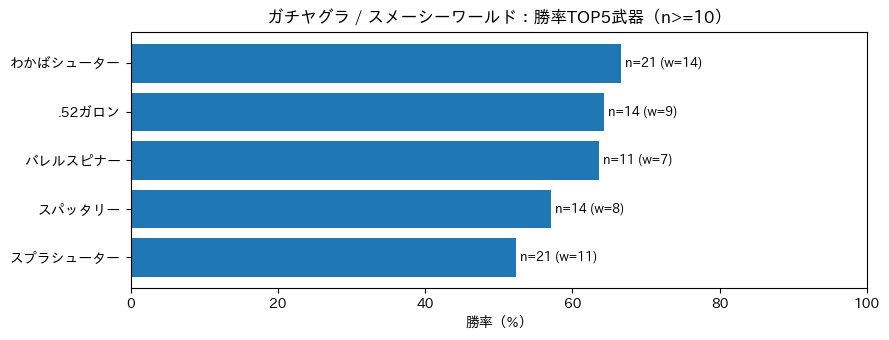

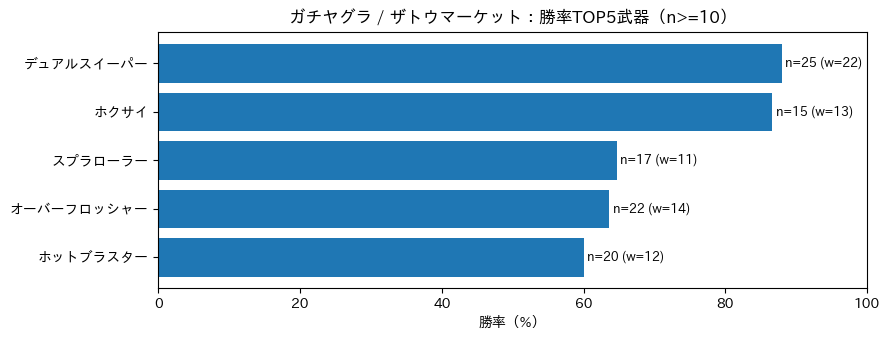

In [5]:
MIN_GAMES = 10   # 少なすぎる試合数は除外
TOP_K = 5        # 各ステージで表示する武器数

MODE_JA = {
    "nawabari": "ナワバリ",
    "area": "ガチエリア",
    "yagura": "ガチヤグラ",
    "hoko": "ガチホコ",
    "asari": "ガチアサリ",
}

# 勝ちフラグ（team == win が勝ち）
df2 = df.with_columns(
    (pl.col("team") == pl.col("win")).cast(pl.Int32).alias("is_win")
)

# ルール×ステージ×武器で勝率
agg = (
    df2.group_by(["mode", "stage", "weapon"])
       .agg(
           pl.len().alias("games"),
           pl.sum("is_win").alias("wins"),
       )
       .with_columns((pl.col("wins") / pl.col("games")).alias("win_rate"))
       .filter(pl.col("games") >= MIN_GAMES)
)

# 表示用に日本語名カラムを追加（辞書で置換）
agg = agg.with_columns([
    pl.col("stage").replace(stage_ja, default=pl.col("stage")).alias("stage_ja"),
    pl.col("weapon").replace(weapon_ja, default=pl.col("weapon")).alias("weapon_ja"),
])

# ルール×ステージごとに上位TOP_K抽出（勝率降順→試合数降順）
top = (
    agg.sort(["mode", "stage", "win_rate", "games"], descending=[False, False, True, True])
       .group_by(["mode", "stage"])
       .head(TOP_K)
)

# mode / stage の一覧（CSVに存在する組み合わせだけ描画）
modes = sorted(top.select("mode").unique().to_series().to_list())

for mode in modes:
    mode_name = MODE_JA.get(mode, mode)
    mode_df = top.filter(pl.col("mode") == mode)

    stages = sorted(mode_df.select("stage").unique().to_series().to_list())
    for stage in stages:
        s_df = (
            mode_df.filter(pl.col("stage") == stage)
                   .sort(["win_rate", "games"], descending=[True, True])
        )

        # 描画用にPythonリストへ
        rows = s_df.select(["weapon_ja", "win_rate", "games", "wins", "stage_ja"]).to_dicts()
        if not rows:
            continue

        stage_name = rows[0]["stage_ja"]

        # barhは下→上に積まれるので、上に強い武器が来るよう reverse
        labels = [r["weapon_ja"] for r in rows][::-1]
        values = [r["win_rate"] * 100 for r in rows][::-1]
        annots = [f"n={int(r['games'])} (w={int(r['wins'])})" for r in rows][::-1]

        fig, ax = plt.subplots(figsize=(9, max(3.5, 0.6 * len(labels))))
        ax.barh(labels, values)

        ax.set_title(f"{mode_name} / {stage_name}：勝率TOP{TOP_K}武器（n>={MIN_GAMES}）")
        ax.set_xlabel("勝率（%）")
        ax.set_xlim(0, 100)

        for i, (x, a) in enumerate(zip(values, annots)):
            ax.text(x + 0.5, i, a, va="center", fontsize=9)

        plt.tight_layout()
        plt.show()
        plt.close(fig)
